In [72]:
import my_module.data_process as dp
import my_module.cal_input as ci
import torch
import torch.nn as nn
# import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [73]:
class Neural_Network(nn.Module):
    def __init__(self,n_feature, n_hidden_l1, n_hidden_l2): #n_hidden_l1 so neural tang thu nhat
                                                  #n_hidden_l2 so neural tang thu hai
        super().__init__() #khoi tao
        self.cal_hidden1 = nn.Linear(n_feature, n_hidden_l1)   #hidden layer 1
        self.relu1 = nn.ReLU()                                 #ham kich hoat layer 1
        self.cal_hidden2 = nn.Linear(n_hidden_l1, n_hidden_l2) #hidden layer 2
        self.relu2 = nn.ReLU()                                 #ham kich hoat layer 2
        self.cal_lout = nn.Linear(n_hidden_l2, 1)              #output layer
        self.out_act = nn.Sigmoid()                #gia tri ra
        
    def forward(self, x_input): #forward
        z1 = self.cal_hidden1(x_input)
        a1 = self.relu1(z1)
        z2 = self.cal_hidden2(a1)
        a2 = self.relu2(z2)
        z3 = self.cal_lout(a2)
        y = self.out_act(z3)
        return y

In [74]:
#Chuyển nhãn sang dạng 0, 1. 0-"-", 1-"+"
#Tham số:
    #file_name: Tên của tập chứa nhãn.
    #num_lable: Nhãn của loại K-PTM nào - (S1, S2, S3, S4) - (1, 2, 3, 4)
#Trả về một ma trận cột chứa nhãn dạng nhị phân của các mẫu trong file có tên file_name
def Lable_To_Bin(file_name, num_lable): 
    path_old = os.getcwd()
    os.chdir("E:\\WinPython-64bit-3.5.4.0Qt5\\notebooks\\Neural_Network_Final\\Data\\Train")
    f_read = open(file_name, "r")
    
    list_lable = ["", "", "", ""]
    
    #Đọc dữ liệu từ file vào list_lable
    i = 0 #index của list_lable
    for line in f_read:
        list_lable[i] = "" + line
        i += 1
        
    #Kiem tra đọc nhãn của loại nào
    re = ""
    for j in range(4):
        if((num_lable) == j):
            re = list_lable[j]
    re = re[0: len(re)-1] #Bo ki tu xuong dong
    
    #Chuyển nhãn của dữ liệu về ma trận cột dạng nhị phân
    matrix_b = np.ones((len(re), 1))
    k = 0 #chi so hang cua matrix_b
    for ch in re:
        if(ch == "+"):
            matrix_b[k][0] = 1
        else:
            matrix_b[k][0] = 0
        k += 1
    os.chdir(path_old)
    f_read.close()
    return matrix_b

In [76]:
#Lớp chứa dữ liệu đầu vào cho mạng
#Tham số của hàm khởi tạo:
    #num_s: Tính xác xuất trên tập s1 or s2 or s3 or s3, num_s = (0, 1, 2, 3)
#Các thuộc tính:
    #list_pro: List chứa xác xuất đầu vào cho mạng.
    #list_lable_bin: List chứa các ma trận cột là nhãn đã chuyển về dạng nhị phân của 5 tập dữ liệu.
    #input_train: Đầu vào cho tập train
    #input_val: Đầu vào cho tập val
    #lable_train: Nhãn của tập train
    #lable_val: Nhãn của tập val
    #self.lable: Nhãn của toàn bộ tập dữ liệu
class ModelData:
    path_train = "E:\\WinPython-64bit-3.5.4.0Qt5\\notebooks\\Neural_Network_Final\\Data\\Train"
    path_pro = "E:\\WinPython-64bit-3.5.4.0Qt5\\notebooks\\Neural_Network_Final\\Data\\K_PTM"
        
    list_pos_name = ["s1_pos.txt", "s2_pos.txt", "s3_pos.txt", "s4_pos.txt"]
    list_neg_name = ["s1_neg.txt", "s3_neg.txt", "s3_neg.txt", "s4_neg.txt"]
        
    list_data_name = ["data1.txt", "data2.txt", "data3.txt", "data4.txt", "data5.txt"]
    list_lable_name = ["lable1.txt", "lable2.txt", "lable3.txt", "lable4.txt", "lable5.txt"]
    
    def __init__(self, num_s): #num_s: 0, 1, 2, 3
        self.num_s = num_s
        self.list_pro = []    #Lưu các xác xuất của tập 1 -> 5
        self.list_lable_bin = []
    def __Cal_Pro(self):    #Tính xác xuất của 5 tập đối với loại K-PTM S_num_s     
        for i in range(4):
            if(i == (self.num_s)):  #Tinh xac suat doi voi tap num_s
                for j in range(5):
                    pro_o = ci.Probability(self.path_train,self.list_data_name[j], self.list_pos_name[i], self.list_neg_name[i], self.path_pro)
                    self.list_pro.append(pro_o.Cal_Probability())
    def __Lable(self):  #Chuyen cac nhan sang danh nhi phan va luu cac thuoc tinh
        for i in range(5):
            self.list_lable_bin.append(Lable_To_Bin(self.list_lable_name[i], self.num_s))
        #Gộp tất cả các nhãn của cả 5 tập dữ liệu với nhau:
        self.lable = self.list_lable_bin[0]
        for i in range(1, 5):
            self.lable = np.concatenate((self.lable, self.list_lable_bin[i]), axis = 0)
            
    def Active(self):
        self.__Cal_Pro()  #Tinh xác xuat
        self.__Lable()    #Chuyển nhãn sang dạng nhị phân
    def Train_And_Val(self, s):    #Ex: s = 0 - Tập data1 là tập val, còn lại gộp lại là tập train
        flag = 0
        for j in range(5):
            if((j != s) & (flag == 0)):
                self.input_train = self.list_pro[j]
                self.lable_train = self.list_lable_bin[j]
                flag = 1
            elif(j != s):
                self.input_train = np.concatenate((self.input_train, self.list_pro[j]), axis = 0)
                self.lable_train = np.concatenate((self.lable_train, self.list_lable_bin[j]), axis = 0)
                
        self.input_val = self.list_pro[s]
        self.lable_val = self.list_lable_bin[s]
        #Gộp ma trận nhãn.

In [209]:
#Thuộc tính:
    #net_num: mạng training cho loại K-PTM Snet_num, tính xác xuất trên Snet_num, net_num = (0, 1, 2, 3)
    #n_hidden_l1: Số neural tầng thứ nhất
    #n_hidden_l2: Số neural tầng thứ hai
class Model:
    Result = []   #Kết quả dự đoán - Thuộc tính lớp
    Lable  = []   #Nhãn của dữ liệu - thuộc tính Lớp
    def __init__(self, data, net_num, n_hidden_l1, n_hidden_l2):
        self.net_num = net_num
        self.n_hidden_l1 = n_hidden_l1
        self.n_hidden_l2 = n_hidden_l2
        self.predicted = np.zeros((6393, 1))
        self.data = data
        
    def Train_And_Predict(self):
        k = 0
        self.Result.append(np.zeros((6393, 1)))#Mỗi lần gọi hàm sẽ khởi tạo cho list kết quả ở lần đó một ma trận 0, sau đó gán sau
        self.Lable.append(self.data.lable)     #thêm nhãn của tập dữ liệu hiện tại.
        for i_data in range(5): #i_data = 0 - dung tap data1 lam tap val
            count = 0
            net = Neural_Network(26, self.n_hidden_l1, self.n_hidden_l2)
            opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
            criterion = nn.BCELoss()
            
            self.data.Train_And_Val(i_data)  #Tính dữ liệu vào train và test
            input_net = torch.from_numpy(self.data.input_train).type(torch.FloatTensor)
            lable_net = torch.from_numpy(self.data.lable_train).type(torch.FloatTensor)
            net.train()
            for t in range(1000):
                opt.zero_grad()                     #Xoa gradient cho lan train tiep theo
                y_hat = net(input_net)              #tinh output
                loss = criterion(y_hat, lable_net)  #tinh loi
                loss.backward()                     #tinh gradinet
                opt.step()
                
            #Predict
            input_val = torch.from_numpy(self.data.input_val).type(torch.FloatTensor)
            net.eval()
            outputs = net(input_val).data.numpy()  #Tính output của mạng với tập val sau khi train
            for i in range(outputs.shape[0]):
                if(outputs[i][0] >= 0.5):
                    self.Result[self.net_num][k][0] = 1  #Gán dữ liệu tính được vào tập Result
                elif(outputs[i][0] < 0.5):
                    self.Result[self.net_num][k][0] = 0  #Gán dữ liệu tính được vào tập Result
                k += 1   
                
                if((outputs[i][0] >= 0.5) & (self.data.lable_val[i][0] == 1) | (outputs[i][0] < 0.5) & (self.data.lable_val[i][0] == 0)):
                    count += 1
            prob = count*100/outputs.shape[0]
            print("predict_data%s" % (i_data), prob)

In [210]:
class MeasuringMetrics:
    def __init__(self, predict_data, lable_data):
        self.predict_data = predict_data
        self.lable_data = lable_data
        self.Aming = 0
        self.Coverage = 0
        self.Accuracy = 0
        #######
    def Cal(self):
        #Yk Nhãn đã được quan sát thử nghiệm
        #Zk Nhãn dự đoán bằng mô hình mạng
        total_sample = 6393
        count = 0
        for i_sample in range(6393):  #List có 4 phần tử tương úng với 4 loại K-PTM
            Yk_inter_Zk = 0
            Yk_uni_Zk = 0
            Yk = 0
            Zk = 0
            for i_list in range(4):
                if((self.predict_data[i_list][i_sample][0]==1) & (self.lable_data[i_list][i_sample][0]==1)):
                    Yk_inter_Zk += 1
                if(self.predict_data[i_list][i_sample][0]==1):
                    Zk += 1
                if(self.lable_data[i_list][i_sample][0]==1):
                    Yk += 1
            if((Yk == 0) & (Zk == 0)):
                Yk_inter_Zk = 1
            if(Yk == 0):
                Yk = 1
            if(Zk == 0):
                Zk = 1
                
            Yk_uni_Zk = Zk + Yk - Yk_inter_Zk
#             print("Yk: ", Yk)
#             print("Zk: ", Zk)
#             print("Yk_inter_Zk: ", Yk_inter_Zk)
            self.Aming += Yk_inter_Zk/Zk
            self.Coverage += Yk_inter_Zk/Yk
            self.Accuracy += Yk_inter_Zk/Yk_uni_Zk       
        self.Aming = self.Aming/total_sample
        self.Coverage = self.Coverage/total_sample
        self.Accuracy = self.Accuracy/total_sample

In [197]:
data0 = ModelData(0)
data1 = ModelData(1)
data2 = ModelData(2)
data3 = ModelData(3)

data0.Active()
data1.Active()
data2.Active()
data3.Active()

In [211]:
model0 = Model(data0, 0, 64, 32)
model1 = Model(data1, 1, 64, 32)
model2 = Model(data2, 2, 64, 32)
model3 = Model(data3, 3, 64, 32)

In [212]:
model0.Train_And_Predict()
model1.Train_And_Predict()
model2.Train_And_Predict()
model3.Train_And_Predict()

predict_data0 86.85446009389672
predict_data1 87.32394366197182
predict_data2 88.96713615023474
predict_data3 87.7151799687011
predict_data4 89.14910226385636
predict_data0 99.37402190923318
predict_data1 99.92175273865415
predict_data2 98.74804381846636
predict_data3 100.0
predict_data4 100.0
predict_data0 99.76525821596245
predict_data1 99.8435054773083
predict_data2 99.76525821596245
predict_data3 99.8435054773083
predict_data4 100.0
predict_data0 90.06259780907668
predict_data1 94.5226917057903
predict_data2 93.74021909233177
predict_data3 95.46165884194053
predict_data4 94.53551912568307


In [208]:
# print(Model.Result[3])
me = MeasuringMetrics(Model.Result, Model.Lable)
me.Cal()
print("Aming   : ",me.Aming)
print("Coverage: ",me.Coverage)
print("Accuracy: ",me.Accuracy)

Aming   :  0.8700401480786276
Coverage:  0.8708743938682935
Accuracy:  0.8555711976641117


In [203]:
a1 = Model.Result
a2 = Model.Lable

x = np.concatenate((a1[0], a1[1], a1[2], a1[3]), axis = 1)
print(x[0:200, 0:4])

[[ 0.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 0.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 0.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0

In [204]:
y = np.concatenate((a2[0], a2[1], a2[2], a2[3]), axis = 1)
print(y[0:30, 0:4])

[[ 0.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


In [ ]:
model1 = Model(data, 0, 64, 32)
model1.Train_And_Predict()

In [ ]:
a = model1.data.list_lable_bin[0]
for i in range(1, 5):
    a = np.concatenate((a, model1.data.list_lable_bin[i]), axis = 0)
count = 0
for j in range(a.shape[0]):
    if(Model.Result[0][j][0] == a[j][0]):
        count += 1
print("probability: ", count*100/a.shape[0])

In [61]:
net = Neural_Network(26, 64, 32)
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [51]:
def Test(model, i_test, re_test):
    model.eval()
    count_t = 0
    outputs = net(i_test)
    outputs = outputs.data.numpy()
    print("output: ")
    print(outputs)
    re_test1 = re_test.data.numpy()
    for i in range(i_test.shape[0]):
        if(((outputs[i][0] >= 0.5) & (re_test1[i][0] == 1.)) | ((outputs[i][0] < 0.5) & (re_test1[i][0] == 0.))):
            count_t += 1
            
    return count_t/i_test.shape[0] *100

In [56]:
def Train(x_input, re_input, model, op, cri):
    loss_list = []
    for t in range(5000):
        op.zero_grad()  #Xoa gradient cho lan train tiep theo
        y_hat = net(x_input) #tinh output
        loss = cri(y_hat, re_input)  #tinh loi
        loss.backward()   #tinh gradinet
        opt.step()        #cap nhat trong so
        loss_list.append(loss.data.numpy())
    return loss_list

In [106]:
a1 = np.array([[1, 2, 4],
               [5, 6, 7]])
a2 = np.array([[2, 3, 4],
               [5, 8, 9]])
a3 = np.array([[2, 4, 5], 
               [8, 9, 0]])
a4 = np.array([[6, 8, 3],
               [4, 8, 9]])
list_matrix = [a1, a2, a3, a4]
dec = 0
i = 0; #Không gộp a4
for j in range(4):
    if((j != i) & (dec == 0)):
        a = list_matrix[j]
        dec = 1
    elif(j != i):
        a = np.concatenate((a, list_matrix[j]), axis = 0)
print(a)

[[2 3 4]
 [5 8 9]
 [2 4 5]
 [8 9 0]
 [6 8 3]
 [4 8 9]]


In [50]:
a = torch.Tensor([2, 4, 5])
c = a.type(torch.DoubleTensor)
print(a.type())
print(c)

torch.FloatTensor
tensor([2., 4., 5.], dtype=torch.float64)


In [51]:
np.zeros((3, 3))

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

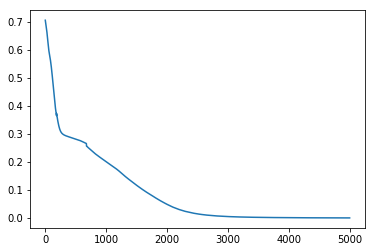

In [62]:
loss = Train(input_1, result_1, net, opt, criterion)
plt.plot(loss)